# Image-Based Wavefront Sensing

In this example, we will show how to implement image-based wavefront sensing based on prysm.  We will use the library both to synthesize the truth data, and as the embedded modeling tool used as part of the optimization routine.

We begin by importing a few classes and functions from prysm and other modules and writing some functions to generate data from zernike coefficients,

In [1]:
from functools import partial

import numpy as np

from scipy.optimize import minimize

from prysm import NollZernike, PSF

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('bmh')

def bake_in_defocus(zernikes, defocus_values):
    return [{**zernikes, **dict(Z4=defocus)} for defocus in defocus_values]

def zerns_idxs_to_dict(zernike_coefs, indices):
    return {k:v for k, v in zip(indices, zernike_coefs)}

# a few extra variables are passed in and aren't used,
# but we're aiming for brevity in this example, not pristine code
# so we just collect them with kwargs and don't use them
def zernikes_to_pupil(zerns, epd, wvl, samples, efl=None, Q=None, phase_mask=None):
    return NollZernike(**zerns,  # coefficients
                       dia=epd, wavelength=wvl,  # physical parameters
                       norm=True, z_unit='waves',  # units and normalization
                       transmission='circle', phase_mask=phase_mask,  # geometry
                       samples=samples)  # sampling

def zernikes_to_psfs(sets_of_zernikes, efl, epd, Q, wvl, samples):
    psfs = []
    for zerns in sets_of_zernikes:
        pupil = zernikes_to_pupil(zerns, epd, wvl, samples)
        psf = PSF.from_pupil(pupil, Q=Q, efl=efl)
        psfs.append(psf)
    return psfs

`zernikes_to_psfs` is quite terse, but has a lot going on.  `zerns` is a dictionary that contains key-value pairs of (Noll) Zernike indexes and their coefficients.  Unpacking it allows us use arbitrary combinations of Zernike terms within the algorithm.  In `zernikes_to_pupil,` `mask_target` is used to avoid masking the phase during optimization, improving performance.  We make explicit that the pupil is circular with `mask`.  It will be used both inside the optimizer and to synthesize data.  We will treat EFL, EPD, Q, and $\lambda$ as known.

Next, we synthesize the truth data.

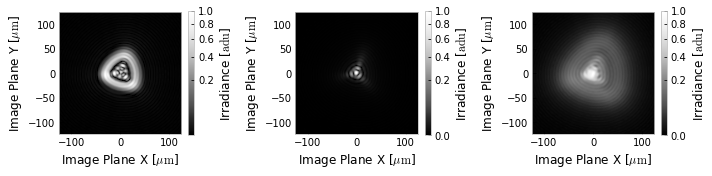

In [2]:
# wavefront data
defocus_values_waves_rms = [-0.65, 0, 0.76]  # noninteger values with nothing special about them
reference_zernikes = dict(Z5=0.012, Z6=0.023, Z7=0.034, Z8=0.045, Z9=0.056, Z10=0.067, Z11=0.12)
wavefront_coefs = bake_in_defocus(reference_zernikes, defocus_values_waves_rms)

# system parameters
efl = 1500
epd = 150  # F/10, e.g. an unobscured telescope with 15 cm aperture
wvl = 0.55 # monochromatic visible system
Q = 2.13   # minorly oversampled
samples = 128 # this is a reasonable number for small OPD and uncomplicated aperture geometry

ztp_kwargs = dict(efl=efl, epd=epd, Q=Q, wvl=wvl, samples=samples)
truth_psfs = zernikes_to_psfs(wavefront_coefs, **ztp_kwargs)

def rowplot_psfs(psfs):
    fig, axs = plt.subplots(ncols=3, figsize=(10,4))
    for psf, ax in zip(psfs, axs):
        psf.plot2d(fig=fig, ax=ax, xlim=125, power=1/2)
        ax.grid(False)

    fig.tight_layout()
    return fig, axs

rowplot_psfs(truth_psfs);

The goal of image-based wavefront sensing is to take these PSFs and use them to estimate the wavefront that generated them (above, `reference_zernikes`) without prior knowledge.  We do this by constructing a nonlinear optimization problem and asking the computer to determine the wavefront coefficients for us.  To that end, we formulate a cost function which calculates the mean square error between the data and the truth,

In [3]:
def optfcn(zernike_coefs, indices, ztp_kwargs, defocuses, truth_psfs):
    base_wavefront_coefs = zerns_idxs_to_dict(zernike_coefs, indices)
    wavefront_coefs = bake_in_defocus(base_wavefront_coefs, defocuses)
    psfs = zernikes_to_psfs(wavefront_coefs, **ztp_kwargs)
    
    # t = truth, m = model.  sum(^2) = mean square error
    diffs = [((t.data - m.data)**2).sum() for t, m in zip(truth_psfs, psfs)]
    
    # normalize by N,
    # psf.size = number of pixels
    diff = sum(diffs) / (len(psfs) * psfs[0].size)
    return diff

coefs = [f'Z{n}' for n in [5, 6, 7, 8, 9, 10, 11]]
optfcn_used = partial(optfcn,
                      indices=coefs,
                      ztp_kwargs=ztp_kwargs,
                      defocuses=defocus_values_waves_rms,
                      truth_psfs=truth_psfs)

This function computes the mean square error between the data in our model PSFs and the truth.  Let's check that it returns zero for the truth:

In [4]:
optfcn_used(reference_zernikes.values())

0.0

This (probably) means we didn't make a mistake.  In your own program, this should be verified more rigorously.  To get a sense for execution time, how quickly can we evaluate it?

In [5]:
%timeit optfcn_used(reference_zernikes.values())

12.6 ms ± 313 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


On the computer this document was written on, the time is 5.5ms per run.  So we should expect much less than a second per iteration of the optimizer; this problem is not so large that running it requires a supercomputer.

All that is left to do is ask the optimizer kindly for the true wavefront, given a guess.  A general guess might be all zeros -- a pupil with no wavefront error.  This does not assume any prior knowledge.  The L-BFGS-B minimizer tends to perform the best for this problem, from experience.

In [6]:
opt_result = minimize(optfcn_used, tuple([0] * len(coefs)), method='L-BFGS-B')
opt_result

      fun: 7.042575279445578e-10
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.46646785e-06, 2.59797657e-06, 3.68414703e-06, 3.74960584e-06,
       4.64570900e-07, 3.23406804e-06, 1.38068190e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 208
      nit: 18
   status: 0
  success: True
        x: array([0.01205381, 0.0231425 , 0.03408251, 0.04508824, 0.05602528,
       0.06708393, 0.12002983])

Casting the `x0` variable to a tuple makes it immutable, which will help when you try to debug one of these problems, but doesn't matter here.

How did the optimizer do?  Well, let's compare the PSFs.

true PSFs


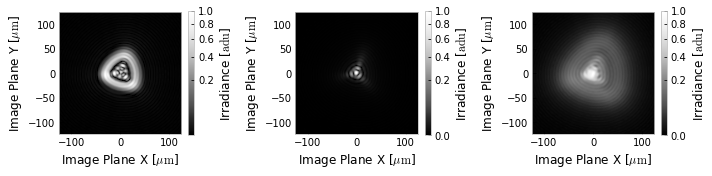

In [7]:
# this is copy pasted from optfcn, but we aren't trying to make the cleanest code right now.
base_wavefront_coefs = zerns_idxs_to_dict(opt_result.x, coefs)
wavefront_coefs = bake_in_defocus(base_wavefront_coefs, defocus_values_waves_rms)
retrieved_psfs = zernikes_to_psfs(wavefront_coefs, **ztp_kwargs)

print('true PSFs')
rowplot_psfs(truth_psfs);

estimated PSFs


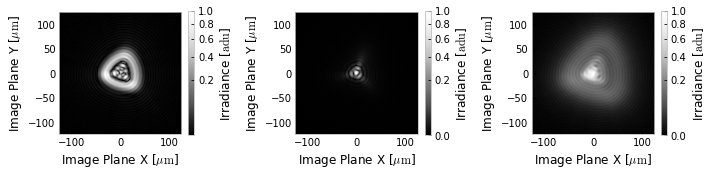

In [8]:
print('estimated PSFs')
rowplot_psfs(retrieved_psfs);

Looks like a good match.  How about the wavefronts?  We have to change the mask target here to the phase visualizes the way we expect.

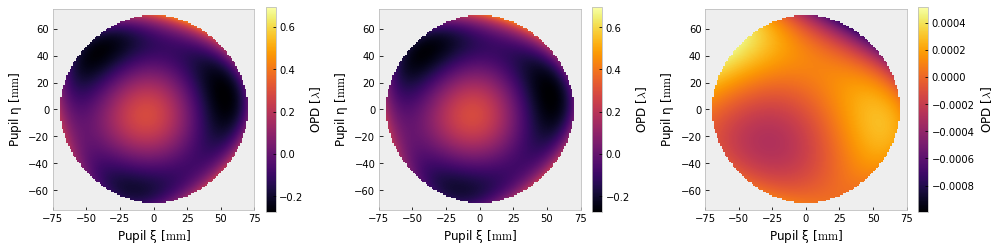

In [9]:
true_wavefront = zernikes_to_pupil(reference_zernikes, **ztp_kwargs, phase_mask='circle')
retrieved_wavefront = zernikes_to_pupil(wavefront_coefs[1], **ztp_kwargs, phase_mask='circle')
elementwise_difference = true_wavefront - retrieved_wavefront

fig, axs = plt.subplots(ncols=3, figsize=(14,8))
true_wavefront.plot2d(fig=fig, ax=axs[0])
retrieved_wavefront.plot2d(fig=fig, ax=axs[1])
elementwise_difference.plot2d(fig=fig, ax=axs[2])


for ax in axs:
    ax.grid(False)

fig.tight_layout()

The optimization function ideally lets us predict the RMS error of the estimate.  Let's compare,

In [10]:
np.sqrt(opt_result.fun), elementwise_difference.rms

(2.6537850853913506e-05, 0.00021508427530044047)

They differ by about a factor of ten, which is unfortunate.  The RMS error is 2 thousandths of a wave; a pretty good result.  What's the peak error?

In [11]:
elementwise_difference.pv

0.0015135008964947683

about 1 1/2 hundredth of a wave, or ~7 nanometers.  Not bad.  Competitive with interferometers, anyway.

More advanced tasks are left to the reader, such as:

* handling of noise

* performance optimization

* improved flexibility w.r.t units, pupil shapes, etc

* estimation of Q or other system parameters

* inclusion of focal plane effects

* extension to N PSFs instead of 3

* use of more terms

* use of other types of phase diversity instead of focus

* formulation of a cost function better connected to the error in the wavefront estimate

* tracking of the optimizer to better understand the course of optimization

* use of other data, such as [MTF](https://static1.squarespace.com/static/578d10066a4963fd85e0aa32/t/5af25e61aa4a99ed9ecfa39c/1525833475522/bdd_ug_thesis_10.pdf)